## Read Config

In [1]:
import os
# Automatically read from your env variables
FIFTYONE_PORT = int(os.getenv("FIFTYONE_PORT", 5151))
FIFTYONE_URI = os.getenv("FIFTYONE_URI", "0.0.0.0")

## Utils Function

In [2]:
import fiftyone as fo

def ext(path):
    _, file_ext = os.path.splitext(path)
    return file_ext

def read_yolo_label(path):
    with open(path, "r") as f:
        data = f.read().splitlines()
    
    bboxes = []
    labels = []
    for obj in data:
        obj = obj.split()
        
        label = int(obj[0])
        cx = float(obj[1])
        cy = float(obj[2])
        w = float(obj[3])
        h = float(obj[4])
        
        x = cx - w/2
        y = cy - h/2
        
        bbox = [x, y, w, h]
        bboxes.append(bbox)
        labels.append(label)
    
    return bboxes, labels

def read_yolo_pred(path, xyxy=False):
    with open(path, "r") as f:
        data = f.read().splitlines()
    
    bboxes = []
    labels = []
    scores = []
    for obj in data:
        obj = obj.split()
        
        label = int(obj[0])
        try:
            score = float(obj[5])
        except:
            score = 1.0
        
        if xyxy:
            x1 = int(obj[1])
            y1 = int(obj[2])
            x2 = int(obj[3])
            y2 = int(obj[4])
            
            x = x1
            y = y1
            w = x2 - x1
            h = y2 - y1
        else:
            cx = float(obj[1])
            cy = float(obj[2])
            w = float(obj[3])
            h = float(obj[4])

            x = cx - w/2
            y = cy - h/2
        
        bbox = [x, y, w, h]
        bboxes.append(bbox)
        labels.append(label)
        scores.append(score)
    
    return bboxes, labels, scores

def create_dataset(imgs_path, labels_path, classes=None, name="eval_det", xyxy=False):
    samples = []
    for img_path, label_path in zip(imgs_path, labels_path):
        sample = fo.Sample(filepath=img_path)
        gt_bboxes, gt_labels = read_yolo_label(label_path)
        gt_detections = [fo.Detection(label=str(label), bounding_box=bbox) for label, bbox in zip(gt_labels, gt_bboxes)]
        sample["ground_truth"] = fo.Detections(detections=gt_detections)
        samples.append(sample)
    print(f'{len(samples)} images found')
    # Create dataset
    dataset = fo.Dataset(name, overwrite=True)
    dataset.add_samples(samples)
    return dataset

def fo_eval_det_dataset(imgs_path, labels_path, preds_path, classes=None, name="eval_det", xyxy=False):
    samples = []
    for img_path, label_path, pred_path in zip(imgs_path, labels_path, preds_path):
        sample = fo.Sample(filepath=img_path)
        gt_bboxes, gt_labels = read_yolo_label(label_path)
        pred_bboxes, pred_labels, pred_scores = read_yolo_pred(pred_path, xyxy=xyxy)
        
        gt_detections = [fo.Detection(label=str(label), bounding_box=bbox) for label, bbox in zip(gt_labels, gt_bboxes)]
        pred_detections = [fo.Detection(label=str(label), bounding_box=bbox, confidence=score) for label, bbox, score in zip(pred_labels, pred_bboxes, pred_scores)]
        
        sample["ground_truth"] = fo.Detections(detections=gt_detections)
        sample["predictions"] = fo.Detections(detections=pred_detections)
        samples.append(sample)

    print(f'{len(samples)} images found')
    
    # Create dataset
    # fo.core.dataset.delete_dataset(name, verbose=True)
    # dataset = fo.Dataset(name, overwrite=True)
    # fo.delete_non_persistent_datasets(verbose=True)
    dataset = fo.Dataset(name, overwrite=True)
    dataset.add_samples(samples)
    
    return dataset

Migrating database to v0.21.0


## Load Dataset

In [3]:
import glob

imgs_dir = "IVTXX17BBXX191024-01_Vehicle Detection Short Distance 5 & 17 Classes Dataset/images"
labels_dir = "IVTXX17BBXX191024-01_Vehicle Detection Short Distance 5 & 17 Classes Dataset/labels"

txt_exts = [".txt"]
imgs_path = sorted([img_path for img_path in sorted(glob.glob(f"{imgs_dir}/**/*.*", recursive=True)) if ext(img_path) not in txt_exts])
labels_path = sorted([label_path for label_path in sorted(glob.glob(f"{labels_dir}/**/*.*", recursive=True)) if ext(label_path) in txt_exts])

assert len(imgs_path)==len(labels_path)

# fiftyone dataset
dataset = create_dataset(imgs_path, labels_path, name="vehicle_dataset")

9224 images found
 100% |███████████████| 9224/9224 [9.2s elapsed, 0s remaining, 911.9 samples/s]       


In [4]:
dataset.persistent = True

In [5]:
dataset = fo.load_dataset("vehicle_dataset")
dataset

Name:        vehicle_dataset
Media type:  image
Num samples: 9224
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


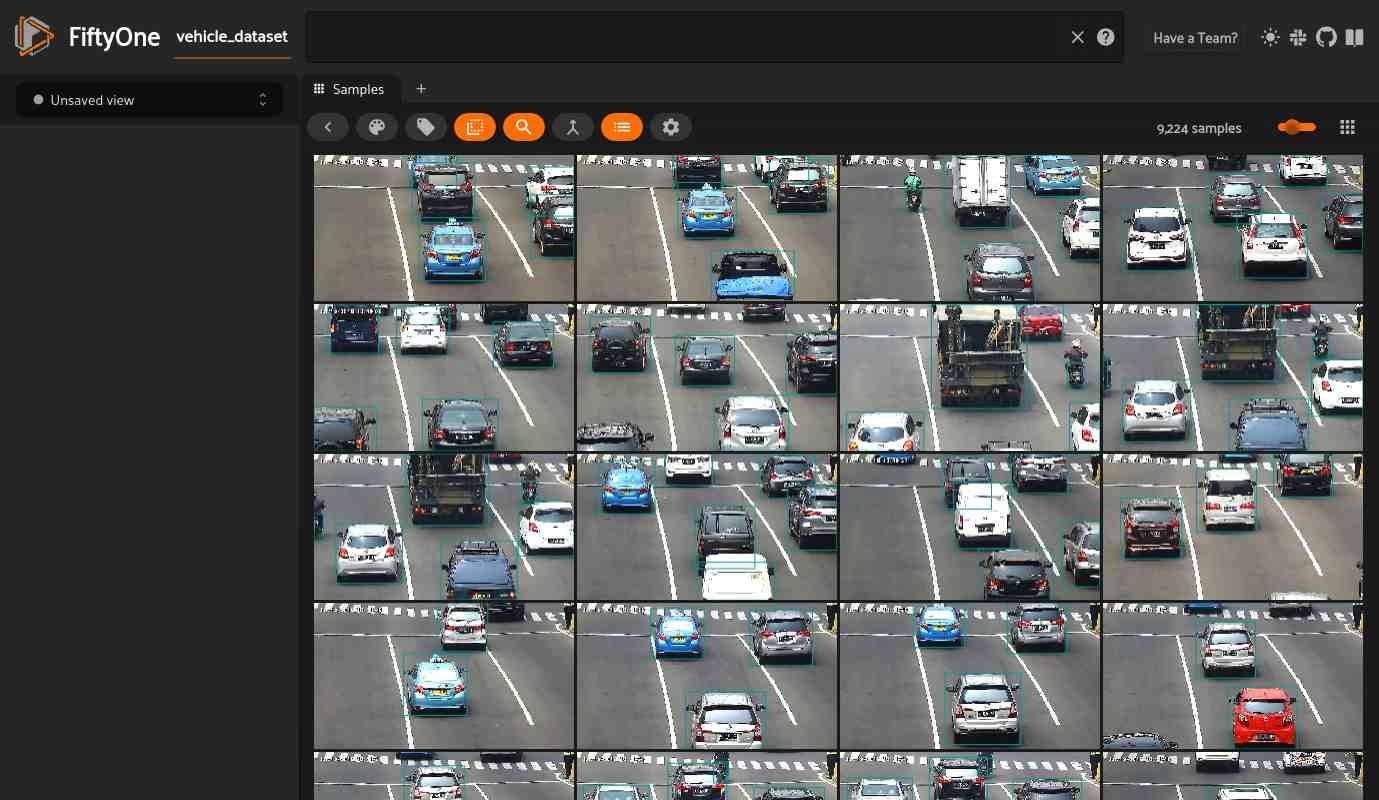


Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.21.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



In [6]:
session = fo.launch_app(dataset)

## Load Model

In [7]:
import fiftyone.zoo as foz

# Load zoo model
model = foz.load_zoo_model("resnext50-32x4d-imagenet-torch")

 100% |████|  766.3Mb/766.3Mb [6.5s elapsed, 0s remaining, 102.4Mb/s]      


/root/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95.8M/95.8M [00:06<00:00, 15.5MB/s]


In [8]:
img_embeddings = dataset.compute_embeddings(model)

Batch: 6498e4c89f84ca9c16e71a67 - 6498e4c89f84ca9c16e71a67                        
Error: image file is truncated (39 bytes not processed)

 100% |███████████████| 9224/9224 [25.7m elapsed, 0s remaining, 5.9 samples/s]      


In [9]:
import numpy as np

np.save("full_frame_embeddings.npy", img_embeddings)

/root/.local/lib/python3.8/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Visualize Embedding Result

In [10]:
from fiftyone import ViewField as F
import fiftyone.brain as fob
import fiftyone.core.utils as fou

def compute_visualization_classification(
    dataset,
    embeddings,
    method="umap",
    brain_key="umap_embeddings",
    ):
    # Compute 2D representation using pre-computed embeddings
    viz_results = fob.compute_visualization(
        dataset,
        embeddings=embeddings,
        num_dims=2,
        method=method,
        brain_key=brain_key,
        verbose=True,
        seed=51)
    return viz_results

def compute_visualization_detection(
    dataset,
    embeddings,
    patches_field="ground_truth"
        ):
    # Compute 2D representation using pre-computed embeddings
    viz_results = fob.compute_visualization(
        dataset,
        patches_field=patches_field,
        embeddings=embeddings,
        num_dims=2,
        brain_key="image_embeddings",
        verbose=True,
        seed=51)
    return viz_results

def compute_uniqueness(dataset, embeddings):
    fob.compute_uniqueness(dataset, embeddings=embeddings)
    dataset.sort_by("uniqueness", reverse=True)
    return dataset

def plot_img_embedding(viz_result, labels="unlabeled"):
    plot = viz_result.visualize(labels=labels)
    return plot

## Plot Full Embeddings

In [11]:
for sample in dataset:
    sample["full_frame"] = "full_frame"
    sample.save()

In [12]:
dataset.first()

<Sample: {
    'id': '6498e4c59f84ca9c16e70e9d',
    'media_type': 'image',
    'filepath': '/workspaces/learn-mlops/IVTXX17BBXX191024-01_Vehicle Detection Short Distance 5 & 17 Classes Dataset/images/11134_2018-07-19_11-38-12_326933.jpg',
    'tags': [],
    'metadata': None,
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '6498e4be9f84ca9c16e6a808',
                'attributes': {},
                'tags': [],
                'label': '0',
                'bounding_box': [
                    0.378125,
                    0.05462962962962964,
                    0.240625,
                    0.40555555555555556,
                ],
                'mask': None,
                'confidence': None,
                'index': None,
            }>,
            <Detection: {
                'id': '6498e4be9f84ca9c16e6a809',
                'attributes': {},
                'tags': [],
                'label': '4',
                'bo

In [13]:
full_viz_results = compute_visualization_classification(dataset, img_embeddings, brain_key="img_embeddings")

Generating visualization...


/root/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword arg

UMAP(random_state=51, verbose=True)
Mon Jun 26 01:34:35 2023 Construct fuzzy simplicial set
Mon Jun 26 01:34:35 2023 Finding Nearest Neighbors
Mon Jun 26 01:34:35 2023 Building RP forest with 10 trees
Mon Jun 26 01:34:39 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Mon Jun 26 01:34:51 2023 Finished Nearest Neighbor Search
Mon Jun 26 01:34:54 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jun 26 01:35:07 2023 Finished embedding


In [14]:
!pip install 'ipywidgets<8,>=7.5'

FigureWidget({
    'data': [{'customdata': array(['6498e4c59f84ca9c16e70e9d', '6498e4c59f84ca9c16e70e9e',
                                   '6498e4c59f84ca9c16e70e9f', ..., '6498e4ce9f84ca9c16e732a2',
                                   '6498e4ce9f84ca9c16e732a3', '6498e4ce9f84ca9c16e732a4'], dtype=object),
              'hovertemplate': ('<b>full_frame: %{text}</b><br>' ... ': %{customdata}<extra></extra>'),
              'line': {'color': '#FF6D04'},
              'mode': 'markers',
              'name': 'full_frame',
              'showlegend': True,
              'text': array(['full_frame', 'full_frame', 'full_frame', ..., 'full_frame',
                             'full_frame', 'full_frame'], dtype='<U10'),
              'type': 'scattergl',
              'uid': 'e7970abf-c8e4-41ad-999d-23a656e90279',
              'x': array([-3.9742475, -4.0253286, -4.011678 , ..., 12.95529  , 12.955577 ,
                          12.970366 ], dtype=float32),
              'y': array([12.344195


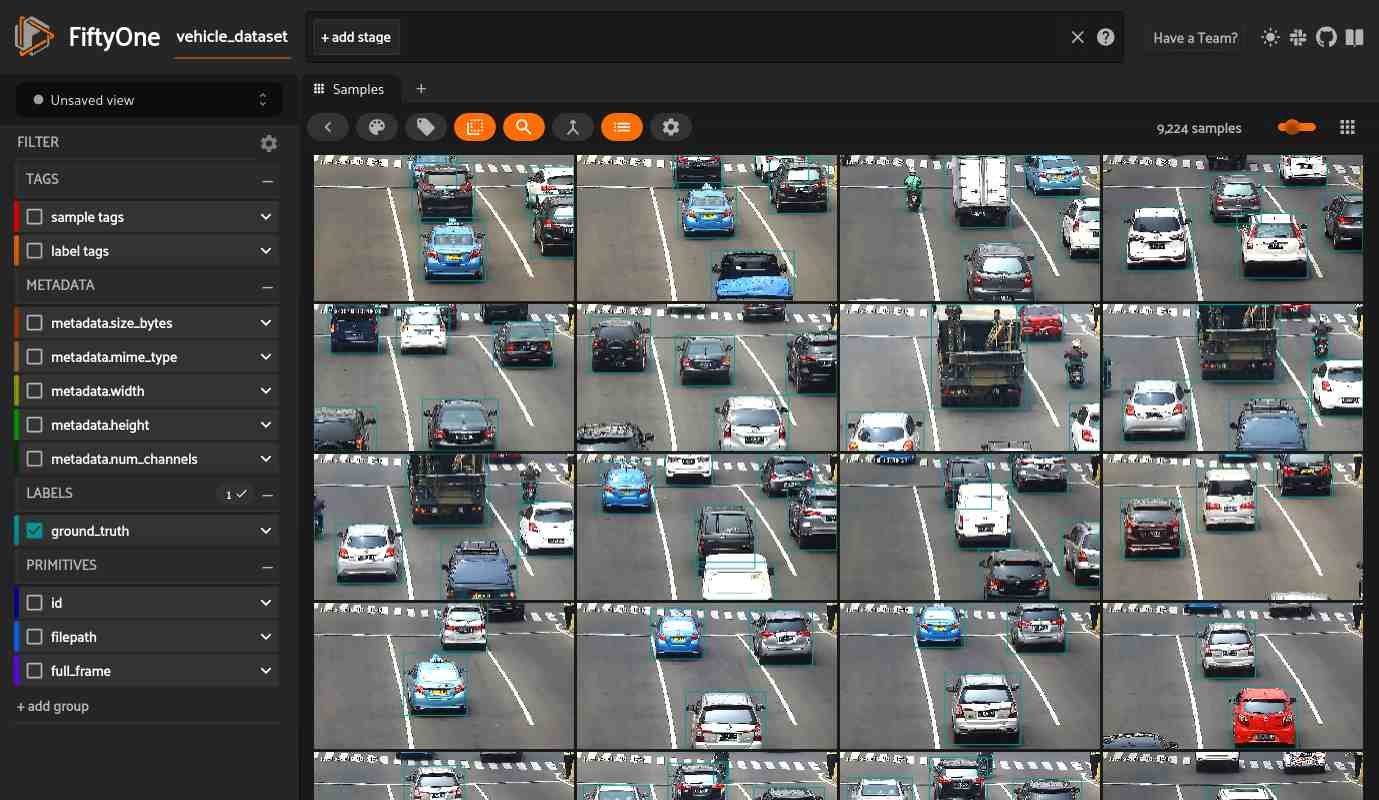

In [15]:
plot_full_frame = plot_img_embedding(full_viz_results, labels="full_frame")
fo.close_app()
plot_full_frame.show()
session = fo.launch_app(dataset, port=FIFTYONE_PORT)
session.plots.attach(plot_full_frame)

In [ ]:
plot_full_frame = plot_img_embedding(full_viz_results, labels="full_frame")
fo.close_app()
session = fo.launch_app(dataset, port=FIFTYONE_PORT)
session.plots.attach(plot_full_frame)

## Compute Detection

In [ ]:
patches_viz_results = compute_visualization_detection(dataset, patches_embeddings)

In [ ]:
plot_patches_embd = plot_img_embedding(patches_viz_results, labels="ground_truth.detections")
fo.close_app()
plot_patches_emb.show()
session = fo.launch_app(dataset, port=FIFTYONE_PORT)
session.plots.attach(plot_patches_embd)

## Compute Uniqueness

In [16]:
dataset = compute_uniqueness(dataset, img_embeddings)

Computing uniqueness...
Uniqueness computation complete


In [17]:
fo.close_app()
session = fo.launch_app(dataset, port=FIFTYONE_PORT)


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



## Compute Similarity

In [ ]:
similarity_results = fob.compute_similarity(
    dataset, model="resnext50-32x4d-imagenet-torch", patches_field="ground_truth", brain_key="gt_sim"
)

In [ ]:
fob.compute_similarity(
    dataset, model="resnext50-32x4d-imagenet-torch", brain_key="gt_sim_img"
)

In [ ]:
dataset.persistent = True

In [ ]:
session.dataset = dataset
session.show()

In [ ]:
# evaluate
results = dataset.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
)

# Print a classification report for the classes
results.print_report()

# Print some statistics about the total TP/FP/FN counts
print("TP: %d" % dataset.sum("eval_tp"))
print("FP: %d" % dataset.sum("eval_fp"))
print("FN: %d" % dataset.sum("eval_fn"))

## Split Dataset

In [18]:
def train_test_split(dataset, percentage=0.25):
    temp_dataset = dataset.clone()
    test_size = int(len(dataset) * percentage)
    test_samples = temp_dataset.take(test_size)
    temp_dataset.delete_samples(test_samples)
    test_dataset = test_samples.clone()
    test_dataset.persistent = True
    temp_dataset.persistent = True
    return temp_dataset, test_dataset

## Split Main Dataset

In [34]:
unique_dataset_samples = dataset.match(F("uniqueness") > 0.6)
common_dataset_samples = dataset.match(F("uniqueness") < 0.6)

In [35]:
unique_dataset_samples

Dataset:     vehicle_dataset
Media type:  image
Num samples: 145
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    full_frame:   fiftyone.core.fields.StringField
    uniqueness:   fiftyone.core.fields.FloatField
View stages:
    1. Match(filter={'$expr': {'$gt': [...]}})


Could not connect session, trying again in 10 seconds



In [36]:
common_dataset_samples

Dataset:     vehicle_dataset
Media type:  image
Num samples: 9079
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    full_frame:   fiftyone.core.fields.StringField
    uniqueness:   fiftyone.core.fields.FloatField
View stages:
    1. Match(filter={'$expr': {'$lt': [...]}})

In [37]:
train_common, test_common = train_test_split(common_dataset_samples)


Could not connect session, trying again in 10 seconds



In [38]:
train_common, test_common

(Name:        2023.06.26.03.50.43
 Media type:  image
 Num samples: 6810
 Persistent:  True
 Tags:        []
 Sample fields:
     id:           fiftyone.core.fields.ObjectIdField
     filepath:     fiftyone.core.fields.StringField
     tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
     metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
     ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
     full_frame:   fiftyone.core.fields.StringField
     uniqueness:   fiftyone.core.fields.FloatField,
 Name:        2023.06.26.03.50.44
 Media type:  image
 Num samples: 2269
 Persistent:  True
 Tags:        []
 Sample fields:
     id:           fiftyone.core.fields.ObjectIdField
     filepath:     fiftyone.core.fields.StringField
     tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
     metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



In [39]:
train_unique, test_unique = train_test_split(unique_dataset_samples)
train_unique, test_unique

(Name:        2023.06.26.03.51.11
 Media type:  image
 Num samples: 109
 Persistent:  True
 Tags:        []
 Sample fields:
     id:           fiftyone.core.fields.ObjectIdField
     filepath:     fiftyone.core.fields.StringField
     tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
     metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
     ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
     full_frame:   fiftyone.core.fields.StringField
     uniqueness:   fiftyone.core.fields.FloatField,
 Name:        2023.06.26.03.51.11.364336
 Media type:  image
 Num samples: 36
 Persistent:  True
 Tags:        []
 Sample fields:
     id:           fiftyone.core.fields.ObjectIdField
     filepath:     fiftyone.core.fields.StringField
     tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
     metadata:     fiftyone.core.fields.EmbeddedDocumentField(fifty


Could not connect session, trying again in 10 seconds



In [40]:
train_common.merge_samples(train_unique)

In [41]:
train_common

Name:        2023.06.26.03.50.43
Media type:  image
Num samples: 6919
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    full_frame:   fiftyone.core.fields.StringField
    uniqueness:   fiftyone.core.fields.FloatField


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



In [42]:
test_common.merge_samples(test_unique)


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



In [43]:
test_common

Name:        2023.06.26.03.50.44
Media type:  image
Num samples: 2305
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    full_frame:   fiftyone.core.fields.StringField
    uniqueness:   fiftyone.core.fields.FloatField

## Export Dataset

In [44]:
for sample in train_common:
    sample.tags.append("train")
    sample.save()


Could not connect session, trying again in 10 seconds



In [45]:
for sample in test_common:
    sample.tags.append("val")
    sample.save()


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



In [46]:
def merge_dataset(list_datasets: list, dataset_name: str):
    merged_dataset = fo.Dataset(name=dataset_name, overwrite=True)
    for dataset in list_datasets:
#         print(dataset)
        for sample in dataset:
#             print(sample)
            merged_dataset.add_sample(sample)
    return merged_dataset


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



In [47]:
# merged dataset
NEW_DATASET_NAME = "vehicle_dataset_processed"
merged_dataset = merge_dataset([train_common, test_common], NEW_DATASET_NAME)
merged_dataset


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



Name:        vehicle_dataset_processed
Media type:  image
Num samples: 9224
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    full_frame:   fiftyone.core.fields.StringField
    uniqueness:   fiftyone.core.fields.FloatField


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



In [73]:
class_mapping = {
0 : "MPV/SUV",
1 : "Sedan",
2 : "Van",
3 : "Angkot",
4 : "Taksi",
5 : "Bajaj",
6 : "Mobil Polisi",
7 : "Mobil pick up box",
8 : "Mobil pick up bermuatan",
9 : "Mobil pick up kosong",
10 : "Mini bus",
11 : "Bus",
12 : "Truk bermuatan",
13 : "Truk tangki",
14 : "Truk tak bermuatan",
15 : "motorcycle",
16 : "pedestrian"}

def rename_label(dataset, class_map):
    for sample in dataset:
        for detection in sample.ground_truth.detections:
            try:
                idx = int(detection.label)
                detection.label = class_map[idx]
            except:
                continue
        sample.save()
    return dataset

In [74]:
merged_dataset = rename_label(merged_dataset, class_mapping)

In [78]:
merged_dataset.persistent = True

In [80]:
fo.close_app()
session = fo.launch_app(merged_dataset, port=FIFTYONE_PORT)
# session.plots.attach(plot_full_frame)

RuntimeError: Failed to post event `state_update` to http://0.0.0.0:5151/event

In [82]:
class_list = [
 "MPV/SUV",
 "Sedan",
 "Van",
 "Angkot",
 "Taksi",
 "Bajaj",
 "Mobil Polisi",
 "Mobil pick up box",
 "Mobil pick up bermuatan",
 "Mobil pick up kosong",
 "Mini bus",
 "Bus",
 "Truk bermuatan",
 "Truk tangki",
 "Truk tak bermuatan",
 "motorcycle",
 "pedestrian"]

In [85]:
!rm -rf vehicle_dataset_new

In [86]:
splits = ["train", "val"]
export_dir = "vehicle_dataset_new"
label_field = "ground_truth"

# Export the splits
for split in splits:
    split_view = merged_dataset.match_tags(split)
    split_view.export(
        export_dir=export_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=label_field,
        split=split,
        classes=class_list
    )

Directory 'vehicle_dataset_new' already exists; export will be merged with existing files


## Check New Distribution

In [88]:
merged_dataset.persistent = True

In [87]:
new_img_embeddings = merged_dataset.compute_embeddings(model)


KeyboardInterrupt



In [ ]:
full_viz_results = compute_visualization_classification(merged_dataset, new_img_embeddings, brain_key="img_embeddings")

In [ ]:
plot_full_frame = plot_img_embedding(full_viz_results, labels="tags")
fo.close_app()
plot_full_frame.show()
session = fo.launch_app(merged_dataset, port=FIFTYONE_PORT)
session.plots.attach(plot_full_frame)